In [1]:
from keras.layers import Input, Dense,Dropout, Flatten,Lambda
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split as tts
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.utils import np_utils,plot_model
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Conv2D
from keras import backend as K
from keras.losses import categorical_hinge,categorical_crossentropy
import tensorflow as tf
from time import time
#from tensorflow.layers import flatten,batch_normialization as batch_norm

Using TensorFlow backend.
/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## load data

In [2]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [4]:
print(x_train.shape)

(50000, 32, 32, 3)


In [5]:
Xtr,Xval,Ytr,Yval = tts(x_train,Y_train,test_size = 0.3)

## import defined modules

In [6]:
import sys
sys.path.append('../')
from cifar_clf import *
from cifar_dae import *

In [7]:
cifar_cnn = Cifar10_CNN(x_train,Y_train,num_batch=128,num_epoch=50)

In [8]:
print(Xtr.shape)

(35000, 32, 32, 3)


In [9]:
#len(cifar_cnn.batch_gen.get_batch())

### train classifer

In [9]:
#cifar_cnn.train("cifar10/cifar_CNN_clf")
cifar_cnn.restore("../logs/cifar10/cifar_CNN_clf")

INFO:tensorflow:Restoring parameters from ../logs/cifar10/cifar_CNN_clf
Success!


In [10]:
cifar_cnn.accuracy_score(x_test,Y_test)

0.6312099358974359

# PGD targeted attacks

In [27]:
#cifar_cnn.targeted_attack(x_test,Y_test,alpha=0.3,eps=64./255.,max_iter =10)

[0/10000] processed
[100/10000] processed
[200/10000] processed
[300/10000] processed
[400/10000] processed
[500/10000] processed
[600/10000] processed
[700/10000] processed
[800/10000] processed
[900/10000] processed
[1000/10000] processed
[1100/10000] processed
[1200/10000] processed
[1300/10000] processed
[1400/10000] processed
[1500/10000] processed
[1600/10000] processed
[1700/10000] processed
[1800/10000] processed
[1900/10000] processed
[2000/10000] processed
[2100/10000] processed
[2200/10000] processed
[2300/10000] processed
[2400/10000] processed
[2500/10000] processed
[2600/10000] processed
[2700/10000] processed
[2800/10000] processed
[2900/10000] processed
[3000/10000] processed
[3100/10000] processed
[3200/10000] processed
[3300/10000] processed
[3400/10000] processed
[3500/10000] processed
[3600/10000] processed
[3700/10000] processed
[3800/10000] processed
[3900/10000] processed
[4000/10000] processed
[4100/10000] processed
[4200/10000] processed
[4300/10000] processed


In [31]:
#X_adv = cifar_cnn.advX
#cifar_cnn.save_path = '../data/'
#cifar_cnn.save_np(X_adv,'cifar_adv2')
X_adv = np.load('../data/cifar_adv.npy')
print(cifar_cnn.accuracy_score(X_adv,Y_test))

0.185897435897


# Train DAE 

In [7]:
cifar_dae = Cifar_DAE(x_train,Y_train,noise_scale = 0.1,dae_type = "over",filter_nums = [64,32],
                      loss_type = "binary_crossentropy",epoch = 10) 
# default is mse nosise!

In [ ]:
#cifar_dae.train_dae()


loss type is binary_crossentropy
dae network is over
train the DAE model with noise gaussian  ( 0.1 )
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
23424/35000 [===================>..........] - ETA: 2s - loss: 0.6243

In [8]:
#cifar_dae.save('../results/cifar_dae.h5')
cifar_dae.load_model('../results/cifar_dae.h5')

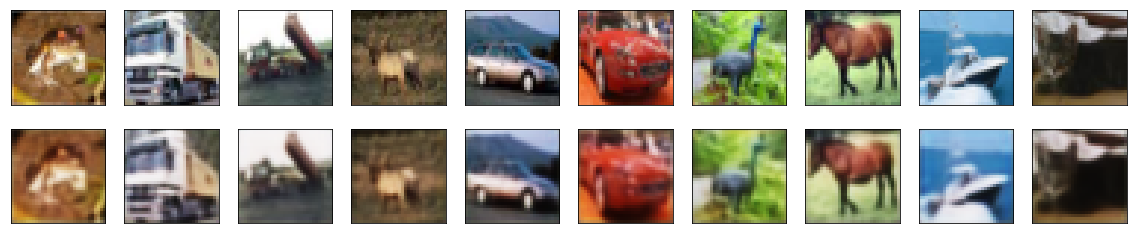

In [14]:
cifar_dae.plot_imgs(x_train,noise_type = 'gaussian',noise_scale = 0.00)

# Generate the corrupted images

In [10]:
_,x_gs = corrupt(x_test,scale =0.2,noise_type = 'gaussian')
_,x_ps = corrupt(x_test,scale =0.2,noise_type = 'peppSalt')

In [16]:
print(cifar_cnn.accuracy_score(x_gs,Y_test))
print(cifar_cnn.accuracy_score(x_ps,Y_test))

0.46734775641
0.359475160256


In [11]:
t1 = time()
x_ps_ds = cifar_dae.apply_DS(x_ps,vr = 0.95,max_iter=30)
print((time()-t1)/len(x_test))
x_gs_ds = cifar_dae.apply_DS(x_gs,vr=0.95)

0.003210334062576294


In [12]:
print(0.003210334062576294*len(x_test))

32.10334062576294


In [18]:
print(cifar_cnn.accuracy_score(x_gs_ds,Y_test))
print(cifar_cnn.accuracy_score(x_ps_ds,Y_test))

0.52594150641
0.459435096154


In [29]:
x_adv_ds = cifar_dae.apply_DS(X_adv,vr=0.95,max_iter=30)

In [30]:
print(cifar_cnn.accuracy_score(X_adv,Y_test))
print(cifar_cnn.accuracy_score(x_adv_ds,Y_test))

0.0215344551282
0.0379607371795


In [95]:
cifar_dae.dae_type

'over'

# SVM classifier

In [21]:
from sklearn import svm
from sklearn.decomposition import PCA
num_te = len(x_test)
pca = PCA(n_components = 32)
x_pca = pca.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_te_pca = pca.transform(x_test.reshape(num_te,-1))
x_ps_pca = pca.transform(x_ps.reshape(num_te,-1))
x_gs_pca = pca.transform(x_gs.reshape(num_te,-1))
x_ps_ds_pca = pca.transform(x_ps_ds.reshape(num_te,-1))
x_gs_ds_pca = pca.transform(x_gs_ds.reshape(num_te,-1))
x_adv_pca = pca.transform(X_adv.reshape(X_adv.shape[0],-1))
x_adv_ds_pca = pca.transform(x_adv_ds.reshape(num_te,-1))

In [23]:
print(y_train.shape)
y_train = y_train.ravel()
y_test = y_test.ravel()

(50000, 1)


In [24]:
clf = svm.SVC(C =10)
clf.fit(x_pca[:10000],y_train[:10000])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
print(clf.score(x_te_pca,y_test))
print(clf.score(x_ps_pca,y_test))
print(clf.score(x_gs_pca,y_test))
print(clf.score(x_ps_ds_pca,y_test))
print(clf.score(x_gs_ds_pca,y_test))
print(clf.score(x_adv_pca,y_test))
print(clf.score(x_adv_ds_pca,y_test))

0.4326
0.4231
0.4373
0.416
0.4272
0.4304
0.419
